In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from keras_tuner import RandomSearch, Objective
import matplotlib.pyplot as plt




In [ ]:
# Define the ticker symbol
ticker_symbol = 'AAPL'

# Set the date range
start_date = '2023-01-01'
end_date = '2023-12-31'

# Download the stock data
data = yf.download(ticker_symbol, start=start_date, end=end_date)

# Display the first few rows of the dataframe
print(data.head())


[*********************100%%**********************]  1 of 1 completed

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2023-01-03  130.279999  130.899994  124.169998  125.070000  124.216301   
2023-01-04  126.889999  128.660004  125.080002  126.360001  125.497505   
2023-01-05  127.129997  127.769997  124.760002  125.019997  124.166641   
2023-01-06  126.010002  130.289993  124.889999  129.619995  128.735229   
2023-01-09  130.470001  133.410004  129.889999  130.149994  129.261612   

               Volume  
Date                   
2023-01-03  112117500  
2023-01-04   89113600  
2023-01-05   80962700  
2023-01-06   87754700  
2023-01-09   70790800  


In [ ]:
# Split the data into training and testing sets
train_data = data[:'2023-11-30']
test_data = data['2023-12-01':]

# Display the shapes of the datasets to verify the split
print("Training data shape:", train_data.shape)
print("Testing data shape:", test_data.shape)


Training data shape: (230, 6)
Testing data shape: (20, 6)


In [ ]:
# Selecting relevant features
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]

# Normalizing data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create a dataset for RNN
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

# Prepare data
time_step = 3
X, y = create_dataset(data_scaled, time_step)
train_size = int(len(X) * 11 / 12)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 5))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 5))

# Define a function to build and train models
def build_and_train_model(model_type):
    if model_type == 'SimpleRNN':
        model = Sequential([SimpleRNN(50, input_shape=(time_step, 5), return_sequences=True), SimpleRNN(50), Dense(1)])
    elif model_type == 'LSTM':
        model = Sequential([LSTM(50, input_shape=(time_step, 5), return_sequences=True), LSTM(50), Dense(1)])
    elif model_type == 'GRU':
        model = Sequential([GRU(50, input_shape=(time_step, 5), return_sequences=True), GRU(50), Dense(1)])

    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, verbose=0)

    # Prediction and performance evaluation
    test_predict = model.predict(X_test)
    test_predict = scaler.inverse_transform(np.concatenate((test_predict, np.zeros((test_predict.shape[0], 4))), axis=1))[:, 0]
    test_y_true = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]
    mape_value = mean_absolute_percentage_error(test_y_true, test_predict)

    return mape_value

# Evaluate all models
results = {}
for model_type in ['SimpleRNN', 'LSTM', 'GRU']:
    mape = build_and_train_model(model_type)
    results[model_type] = mape

# Display the results
for model_type, mape in results.items():
    print(f'{model_type} Mean Absolute Percentage Error (MAPE): {mape * 100:.2f}%')

1/1 [==============================] - 1s 770ms/step
SimpleRNN Mean Absolute Percentage Error (MAPE): 0.99%
LSTM Mean Absolute Percentage Error (MAPE): 0.67%
GRU Mean Absolute Percentage Error (MAPE): 0.66%


In [ ]:
# Model builder function
def build_model(hp):
    model_type = hp.Choice('model_type', values=['SimpleRNN', 'LSTM', 'GRU'])
    model = Sequential()
    model.add({
        'SimpleRNN': SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32),
                               input_shape=(time_step, 5), return_sequences=True),
        'LSTM': LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32),
                     input_shape=(time_step, 5), return_sequences=True),
        'GRU': GRU(units=hp.Int('units', min_value=32, max_value=128, step=32),
                   input_shape=(time_step, 5), return_sequences=True)
    }[model_type])
    model.add({
        'SimpleRNN': SimpleRNN(units=hp.Int('units', min_value=32, max_value=128, step=32)),
        'LSTM': LSTM(units=hp.Int('units', min_value=32, max_value=128, step=32)),
        'GRU': GRU(units=hp.Int('units', min_value=32, max_value=128, step=32))
    }[model_type])
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Set up Keras Tuner
tuner = RandomSearch(
    build_model,
    objective=Objective("val_loss", direction="min"),
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='hparam_tuning'
)

# Split data into training and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Run the hyperparameter search
tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Print the best model's architecture
best_model.summary()

Trial 10 Complete [00h 00m 08s]
val_loss: 0.0009253963944502175

Best val_loss So Far: 0.0007570114685222507
Total elapsed time: 00h 01m 20s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 96)             29664     
                                                                 
 gru_1 (GRU)                 (None, 96)                55872     
                                                                 
 dense (Dense)               (None, 1)                 97        
                                                                 
Total params: 85633 (334.50 KB)
Trainable params: 85633 (334.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


1/1 [==============================] - 2s 2s/step


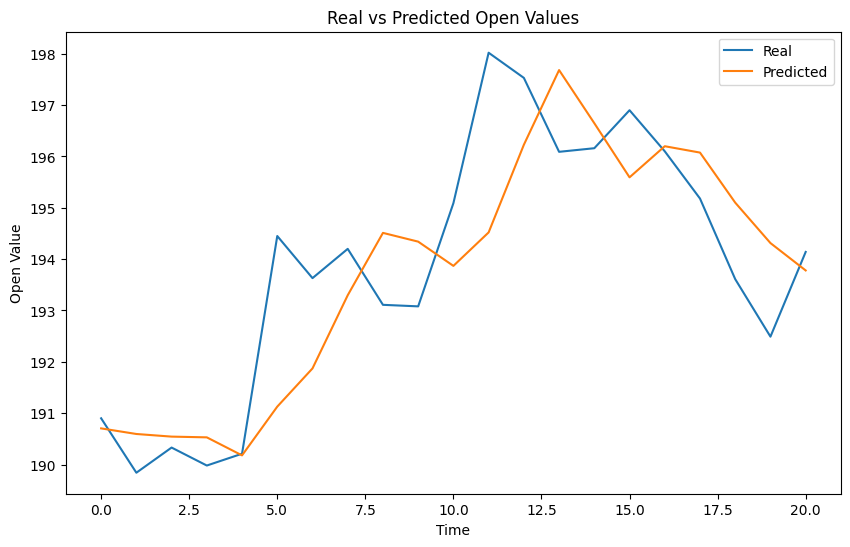

In [ ]:

# Generate predictions for the test data
test_predictions = best_model.predict(X_test)
test_predictions = scaler.inverse_transform(np.concatenate((test_predictions, np.zeros((test_predictions.shape[0], 4))), axis=1))[:, 0]

# Inverse transform the actual test 'Open' values
actual_test_values = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 4))), axis=1))[:, 0]

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(actual_test_values, label='Real')
plt.plot(test_predictions, label='Predicted')
plt.title('Real vs Predicted Open Values')
plt.xlabel('Time')
plt.ylabel('Open Value')
plt.legend()
plt.show()


The closeness of the two lines in the plot indicates a good fit using GRU.
The low validation loss (val_loss: 0.00092539) means on average predictions are very close to the actual values during validation. This aligns with the visual representation in the plot.
In conclusion, the GRU-based model seems to perform well on the task of predicting stock 'Open' values.